<a href="https://colab.research.google.com/github/Shumookh/ChemLLMathon.NanoAI/blob/main/ChemLLMathone_NanoAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [504]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
#from datasets import load_dataset, DatasetDict, DataSet
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
#import evaluate
import torch
import random
from prettytable import PrettyTable
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [505]:
# upload the file
file_path = "DataSet-2.xlsx"
excel_data = pd.ExcelFile(file_path)

In [506]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing


In [507]:
data_sheet = excel_data.parse("Data")

In [508]:
data_sheet.head()

,Proplyene Oxide,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Acetone,Unnamed: 9,...,Unnamed: 30,Unnamed: 31,methanol,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39
0,MS,NaN,CNMR\t,NaN,HNMR,NaN,IR,NaN,MS,NaN,...,IR,NaN,MS,NaN,CNMR,NaN,HNMR,NaN,IR,NaN
1,M/S,Intensity,ppm,Intensity,ppm,Intensity,Wavenumber,transmission,M/S,Intensity,...,Wavenumber,transmission,M/S,Intensity,ppm,Intensity,ppm,Intensity,Wavenumber,transmission
2,14,3,48.17,795,3.11,32,747,26,14,2.9,...,588,17,14,1.7,50.05,1000,3.761,36,662,58
3,15,10.8,47.94,1000,3.08,38,828,4,15,23.1,...,618,81,15,12.4,NaN,NaN,3.699,135,1030,4
4,25,1.7,18.08,860,3.066,48,896,44,26,3.5,...,691,14,28,4.6,NaN,NaN,3.642,188,1116,62


In [509]:
round(data_sheet.describe(),2)

,Proplyene Oxide,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Acetone,Unnamed: 9,...,Unnamed: 30,Unnamed: 31,methanol,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39
count,22,21.0,5,4,40,39,33,32,19,18.0,...,37,36,10,9,3,2,8,7,12,11
unique,22,20.0,5,4,40,35,33,22,19,17.0,...,36,24,10,9,3,2,8,7,12,10
top,MS,1.3,CNMR\t,Intensity,HNMR,160,IR,84,MS,3.1,...,1646,81,MS,Intensity,CNMR,Intensity,HNMR,Intensity,IR,8
freq,1,2.0,1,1,1,3,1,6,1,2.0,...,2,4,1,1,1,1,1,1,1,2


In [510]:
# extract the headers separately
subset = data_sheet.iloc[2:, :]
headers = data_sheet.iloc[:2, :]
headers_df = headers.T.reset_index()

headers_df["index"] = headers_df["index"].replace(r'^Unnamed.*', np.nan, regex=True).fillna(method="ffill")
headers_df[0] = headers_df[0].fillna(method='ffill')

headers_df = headers_df.iloc[:, [0, 1]]
headers_df.drop_duplicates(inplace=True)

In [511]:
lengths = []
dataframes = []
for col_num in range(0, data_sheet.shape[1], 2):
    small_df = data_sheet.iloc[2:, col_num:col_num+2]
    small_df.dropna(inplace=True)
    small_df.rename(columns={small_df.columns[0]: "Column1", small_df.columns[1]: "Column2"}, inplace=True)
    dataframes.append(small_df)
    # append twice
    lengths.append(len(small_df))
stacked_df = pd.concat(dataframes, axis=0, ignore_index=True)

In [512]:
repeated_headers_df = headers_df.reindex(headers_df.index.repeat(lengths)).reset_index(drop=True)

In [513]:
prepared_df = pd.concat([repeated_headers_df, stacked_df], axis=1)
prepared_df.columns = ["category", "feature", "first", "second"]
prepared_df.head()

,category,feature,first,second
0,Proplyene Oxide,MS,14,3
1,Proplyene Oxide,MS,15,10.8
2,Proplyene Oxide,MS,25,1.7
3,Proplyene Oxide,MS,26,27.7
4,Proplyene Oxide,MS,27,49.8


In [514]:
prepared_df.describe()

,category,feature,first,second
count,309,309,309,309
unique,5,5,266,184
top,Proplyene Oxide,IR,38,1000
freq,92,110,4,10


In [515]:
prepared_df['feature'] = prepared_df['feature'].str.replace("\t", "")

In [516]:
prepared_df['feature'].value_counts()

,count
feature,
IR,110
HNMR,93
MS,90
CNMR,16


In [517]:
prepared_df['first'] = prepared_df['first'].apply(lambda x: str(x).split()[0]).astype(float)
mapping = {
    "MS": 1,
    "CNMR": 2,
    "HNMR": 3,
    "IR": 4
}
prepared_df['feature'] = prepared_df['feature'].map(mapping).astype(int)

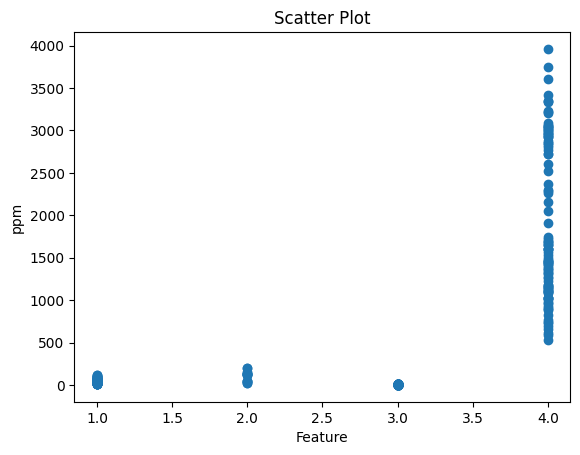

In [518]:
# Scatter plot with day against tip
plt.scatter(prepared_df['feature'], prepared_df['first'])

# Adding Title to the Plot
plt.title("Scatter Plot")

# Setting the X and Y labels
plt.xlabel('Feature')
plt.ylabel('ppm')

plt.show()

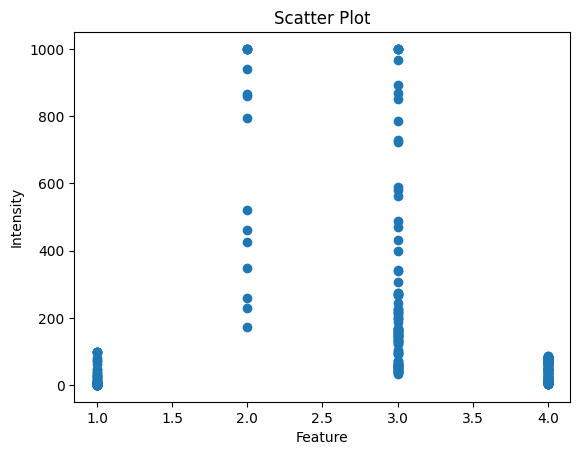

In [519]:
# Scatter plot with day against tip
plt.scatter(prepared_df['feature'], prepared_df['second'])

# Adding Title to the Plot
plt.title("Scatter Plot")

# Setting the X and Y labels
plt.xlabel('Feature')
plt.ylabel('Intensity')

plt.show()

# Training the model - baseline

In [520]:
# Prepare the data
X = prepared_df[["first", "second", "feature"]]
y = prepared_df["category"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Initialize and train the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5483870967741935


In [554]:
# Initialize KFold for 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=90)

# Perform cross-validation
rf_classifier = RandomForestClassifier(random_state=42)
scores = cross_val_score(rf_classifier, X, y, cv=kf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.47058824 0.23529412 0.41176471 0.3125     0.1875     0.25
 0.25       0.25       0.5        0.1875    ]
Mean accuracy: 0.30551470588235297
Standard deviation: 0.10883160244300098


# Training with normalizing

In [522]:
def normalize(df, min_max_df, column):
    min_value = min_max_df[f'min_{column}']
    max_value = min_max_df[f'max_{column}']

    df[f'{column}'] = (df[column] - min_value) / (max_value - min_value)

    return df

In [523]:
# Prepare the data
X = prepared_df[["first", "second", "feature"]]
y = prepared_df["category"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
min_max_train = X_train[['feature', 'first', 'second']].groupby('feature').agg(
    min_first=('first', 'min'),
    max_first=('first', 'max'),
    min_second=('second', 'min'),
    max_second=('second', 'max'))
X_train = normalize(X_train, min_max_train, 'first')
X_train = normalize(X_train, min_max_train, 'second')

min_max_test = X_test[['feature', 'first', 'second']].groupby('feature').agg(
    min_first=('first', 'min'),
    max_first=('first', 'max'),
    min_second=('second', 'min'),
    max_second=('second', 'max'))
X_test = normalize(X_test, min_max_test, 'first')
X_test = normalize(X_test, min_max_test, 'second')

# Initialize and train the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.27419354838709675


# Training the model - Decision tree Classifier

In [524]:
# Prepare the data
X = prepared_df[["first", "second", "feature"]]
y = prepared_df["category"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
rf_classifier2 = DecisionTreeClassifier()
rf_classifier2.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier2.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5161290322580645


In [525]:
# Initialize KFold for 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=90)

# Perform cross-validation
rf_classifier2 = DecisionTreeClassifier()
scores = cross_val_score(rf_classifier, X, y, cv=kf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.35483871 0.61290323 0.48387097 0.51612903 0.38709677 0.5483871
 0.4516129  0.61290323 0.51612903 0.36666667]
Mean accuracy: 0.4850537634408602
Standard deviation: 0.08962151115597185


# Training the model - SVM

In [526]:
# Prepare the data
X = prepared_df[["first", "second", "feature"]]
y = prepared_df["category"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [527]:
cols = X_train.columns

In [528]:
# Feature Scaling
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [529]:

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [530]:
X_train.describe()

,first,second,feature
count,2.470000e+02,2.470000e+02,2.470000e+02
mean,-1.222594e-16,-8.270487e-17,-1.797932e-16
std,1.002030e+00,1.002030e+00,1.002030e+00
min,-6.719048e-01,-5.670465e-01,-1.414714e+00
25%,-6.661980e-01,-5.335328e-01,-1.414714e+00
50%,-6.217094e-01,-3.351904e-01,2.219809e-01
75%,5.111237e-01,-8.647201e-02,1.040328e+00
max,3.029725e+00,3.644304e+00,1.040328e+00


# Run SVM with default hyperparameters

In [531]:
# instantiate classifier with default hyperparameters
svc=SVC()

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.3226


In [532]:
# Run SVM with rbf kernel and C=1000.0
# instantiate classifier with rbf kernel and C=1000
svc=SVC(C=1000.0)

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=1000.0 : 0.4032


In [533]:
# Run SVM with linear kernel
# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0)

# fit classifier to training set
linear_svc.fit(X_train,y_train)

# make predictions on test set
y_pred_test=linear_svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score with linear kernel and C=1.0 : 0.3387


In [534]:
# SVM with linear kernel and C=1000.0
# instantiate classifier with linear kernel and C=100.0
linear_svc100=SVC(kernel='linear', C=1000.0)

# fit classifier to training set
linear_svc100.fit(X_train, y_train)

# make predictions on test set
y_pred=linear_svc100.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with linear kernel and C=1000.0 : 0.3387


In [535]:
y_pred_train = linear_svc.predict(X_train)

y_pred_train

array(['acetophenone', 'Phenol', 'Proplyene Oxide', 'Proplyene Oxide',
       'Proplyene Oxide', 'acetophenone', 'Phenol', 'Proplyene Oxide',
       'Proplyene Oxide', 'acetophenone', 'acetophenone',
       'Proplyene Oxide', 'Phenol', 'Proplyene Oxide', 'Proplyene Oxide',
       'Phenol', 'acetophenone', 'acetophenone', 'acetophenone',
       'acetophenone', 'acetophenone', 'Proplyene Oxide', 'acetophenone',
       'acetophenone', 'Proplyene Oxide', 'Proplyene Oxide', 'Phenol',
       'Proplyene Oxide', 'acetophenone', 'Phenol', 'acetophenone',
       'Phenol', 'acetophenone', 'Proplyene Oxide', 'acetophenone',
       'acetophenone', 'Proplyene Oxide', 'Proplyene Oxide',
       'acetophenone', 'Proplyene Oxide', 'Proplyene Oxide',
       'Proplyene Oxide', 'acetophenone', 'Proplyene Oxide', 'Phenol',
       'acetophenone', 'Proplyene Oxide', 'Phenol', 'Proplyene Oxide',
       'Proplyene Oxide', 'acetophenone', 'Proplyene Oxide',
       'Proplyene Oxide', 'acetophenone', 'acetophenone

In [536]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.3320


In [537]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(linear_svc.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(linear_svc.score(X_test, y_test)))

Training set score: 0.3320
Test set score: 0.3387


In [538]:
# Run SVM with polynomial kernel
# instantiate classifier with polynomial kernel and C=1.0
poly_svc=SVC(kernel='poly', C=1.0)

# fit classifier to training set
poly_svc.fit(X_train,y_train)

# make predictions on test set
y_pred=poly_svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with polynomial kernel and C=1.0 : 0.2742


In [539]:
# instantiate classifier with polynomial kernel and C=100.0
poly_svc100=SVC(kernel='poly', C=100.0)

# fit classifier to training set
poly_svc100.fit(X_train, y_train)

# make predictions on test set
y_pred=poly_svc100.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with polynomial kernel and C=1.0 : 0.3387


In [540]:
# instantiate classifier with sigmoid kernel and C=1000.0
sigmoid_svc100=SVC(kernel='sigmoid', C=1000.0)

# fit classifier to training set
sigmoid_svc100.fit(X_train,y_train)

# make predictions on test set
y_pred=sigmoid_svc100.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with sigmoid kernel and C=1000.0 : 0.2258


In [541]:
# classification report
print(classification_report(y_test, y_pred_test))

                 precision    recall  f1-score   support

        Acetone       0.00      0.00      0.00         8
         Phenol       0.57      0.27      0.36        15
Proplyene Oxide       0.40      0.60      0.48        20
   acetophenone       0.20      0.45      0.28        11
       methanol       0.00      0.00      0.00         8

       accuracy                           0.34        62
      macro avg       0.23      0.26      0.22        62
   weighted avg       0.30      0.34      0.29        62



# HNMR - MAX Data

In [542]:
data_sheet = excel_data.parse("HNMR-Mix")
data_sheet = data_sheet.replace({"\t": ""}, regex=True)
data_sheet.head()

,Phenol + Proplyene Oxide,Unnamed: 1,Acetone + Proplyene Oxide,Unnamed: 3,acetophenone + Proplyene Oxide,Unnamed: 5
0,ppm,Intensity,ppm,Intensity,ppm,Intensity
1,7.262,581,2.1621,1000,8.004,72
2,7.259,227,3.11,32,7.987,72
3,7.256,219,3.08,38,7.967,39
4,7.249,144,3.066,48,7.927,57


In [543]:
data_sheet.shape

(71, 6)

In [544]:
dataframes = []
for col_num in range(0, data_sheet.shape[1], 2):
    small_df = data_sheet.iloc[1:, col_num:col_num+2]
    small_df.dropna(inplace=True)
    small_df.rename(columns={small_df.columns[0]: "ppm", small_df.columns[1]: "intensity"}, inplace=True)
    dataframes.append(small_df)
stacked_df = pd.concat(dataframes, axis=0, ignore_index=True)
stacked_df.shape

(163, 2)

In [545]:
stacked_df['category'] = ["Phenol + Proplyene Oxide"] * len(dataframes[0]) + ["Acetone + Proplyene Oxide"] * len(dataframes[1]) + ["acetophenone + Proplyene Oxide"] * len(dataframes[2])
stacked_df.head()

,ppm,intensity,category
0,7.262,581,Phenol + Proplyene Oxide
1,7.259,227,Phenol + Proplyene Oxide
2,7.256,219,Phenol + Proplyene Oxide
3,7.249,144,Phenol + Proplyene Oxide
4,7.246,432,Phenol + Proplyene Oxide


In [546]:
prepared_df = stacked_df

# Random Forest model

In [547]:
# Prepare the data
X = prepared_df[["ppm", "intensity"]]
y = prepared_df["category"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)

# Initialize and train the RandomForestClassifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.48


# ANN Models

In [548]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Import LabelEncoder for categorical encoding
from sklearn.metrics import accuracy_score

# Extract features and target labels from the prepared DataFrame
X = prepared_df[["ppm", "intensity"]].values  # Feature matrix containing 'ppm' and 'intensity'
y = prepared_df["category"].values  # Target vector containing categorical labels

# Encode categorical labels to numerical values
label_encoder = LabelEncoder()  # Initialize LabelEncoder to convert categories to numbers
y = label_encoder.fit_transform(y)  # Transform labels to numerical format

# Split the data into training and testing sets (85% training, 15% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

# Standardize the features to have zero mean and unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit the scaler on training data and transform it
X_test = scaler.transform(X_test)  # Transform the test data using the fitted scaler

# Convert standardized data to PyTorch tensors for model training and evaluation
X_train_tensor = torch.FloatTensor(X_train)  # Training features as FloatTensor
X_test_tensor = torch.FloatTensor(X_test)  # Testing features as FloatTensor
y_train_tensor = torch.LongTensor(y_train)  # Training labels as LongTensor (numerical)
y_test_tensor = torch.LongTensor(y_test)  # Testing labels as LongTensor

# Define the artificial neural network model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(2, 80)   # First layer (2 inputs, 80 outputs)
        self.fc2 = nn.Linear(80, 160)  # Second layer (80 inputs, 160 outputs)
        self.fc3 = nn.Linear(160, 80)  # Third layer (160 inputs, 80 outputs)
        self.fc4 = nn.Linear(80, len(set(y)))  # Final layer (outputs equal to number of categories)

    def forward(self, x):
        # Define the forward pass through the network with ReLU activations
        x = torch.relu(self.fc1(x))  # Activation for the first layer
        x = torch.relu(self.fc2(x))  # Activation for the second layer
        x = torch.relu(self.fc3(x))  # Activation for the third layer
        x = self.fc4(x)               # Output layer (no activation needed here)
        return x

# Initialize the model, loss function, and optimizer
model = ANNModel()  # Instantiate the ANN model
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Use Adam optimizer with a learning rate of 0.001

# Train the model for a specified number of epochs
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Reset gradients to zero before backpropagation
    outputs = model(X_train_tensor)  # Forward pass: compute model outputs
    loss = criterion(outputs, y_train_tensor)  # Compute loss using the output and true labels
    loss.backward()  # Backpropagation: compute gradients
    optimizer.step()  # Update model parameters based on gradients

    # Print loss at every 10 epochs for monitoring
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient tracking for inference
    y_pred_tensor = model(X_test_tensor)  # Get predictions from the model
    _, y_pred = torch.max(y_pred_tensor, 1)  # Extract the class with the highest probability

# Evaluate the model's performance using accuracy
accuracy = accuracy_score(y_test_tensor.numpy(), y_pred.numpy())  # Calculate accuracy score
print(f"Accuracy: {accuracy:.4f}")  # Print the accuracy result

Epoch [10/100], Loss: 1.0240
Epoch [20/100], Loss: 0.9385
Epoch [30/100], Loss: 0.8822
Epoch [40/100], Loss: 0.8508
Epoch [50/100], Loss: 0.8305
Epoch [60/100], Loss: 0.8190
Epoch [70/100], Loss: 0.8121
Epoch [80/100], Loss: 0.8070
Epoch [90/100], Loss: 0.8030
Epoch [100/100], Loss: 0.7994
Accuracy: 0.5102


Genatic algrithem with ANN

In [558]:
#importing libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

# Extract features and target labels from the prepared DataFrame
X = prepared_df[["ppm", "intensity"]].values  # Feature matrix containing 'ppm' and 'intensity'
y = prepared_df["category"].values  # Target vector containing categories

# Encode categorical labels into numerical values using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert text labels to numerical format

# Split the dataset into training and testing sets (85% training, 15% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)

# Feature Normalization: Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test = scaler.transform(X_test)  # Transform the test data using the same parameters

# Convert data to PyTorch tensors for processing
X_train_tensor = torch.FloatTensor(X_train)  # Convert training features to Tensor
X_test_tensor = torch.FloatTensor(X_test)  # Convert testing features to Tensor
y_train_tensor = torch.LongTensor(y_train)  # Convert training labels to Tensor
y_test_tensor = torch.LongTensor(y_test)  # Convert testing labels to Tensor

# Define the neural network model with four layers
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(2, 80)  # First layer (2 inputs, 80 outputs)
        self.fc2 = nn.Linear(80, 160)  # Second layer (80 inputs, 160 outputs)
        self.fc3 = nn.Linear(160, 80)  # Third layer (160 inputs, 80 outputs)
        self.fc4 = nn.Linear(80, len(set(y)))  # Final layer (output size equals number of classes)

    def forward(self, x):
        # Define the forward pass through the network
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to the second layer
        x = torch.relu(self.fc3(x))  # Apply ReLU activation to the third layer
        x = self.fc4(x)               # Output layer
        return x

# Define the Genetic Algorithm class for model optimization
class GeneticAlgorithm:
    def __init__(self, model, population_size, mutation_rate):
        # Initialize the genetic algorithm with a model and parameters
        self.model = model
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.population = [self.random_weights() for _ in range(population_size)]  # Initialize population

    def random_weights(self):
        # Generate random weights for the model parameters
        return [torch.rand_like(param) for param in self.model.parameters()]

    def evaluate(self, X, y):
        # Evaluate the model's performance on the given dataset
        self.model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            outputs = self.model(X)  # Forward pass
            _, predictions = torch.max(outputs, 1)  # Get predicted classes
            accuracy = accuracy_score(y.numpy(), predictions.numpy())  # Calculate accuracy
        return accuracy

    def mutate(self, weights):
        # Apply mutation to the weights based on the mutation rate
        for i in range(len(weights)):
            if np.random.rand() < self.mutation_rate:
                weights[i] += torch.randn_like(weights[i]) * 0.01  # Adjust weights
        return weights

    def crossover(self, parent1, parent2):
        # Perform crossover between two parent weight sets to produce a child
        child = []
        for p1, p2 in zip(parent1, parent2):
            if np.random.rand() > 0.5:
                child.append(p1.clone())  # Select from parent 1
            else:
                child.append(p2.clone())  # Select from parent 2
        return child

    def run(self, X, y, num_generations):
        # Execute the genetic algorithm for a specified number of generations
        for generation in range(num_generations):
            fitness_scores = [self.evaluate(X, y) for weights in self.population]  # Evaluate fitness of each individual
            best_indices = np.argsort(fitness_scores)[-2:]  # Select the top two individuals
            print(f'Generation {generation}: Best Accuracy: {fitness_scores[best_indices[-1]]:.4f}')  # Log best accuracy

            new_population = []
            for i in range(self.population_size // 2):
                # Generate new population through crossover and mutation
                parent1 = self.population[best_indices[0]]
                parent2 = self.population[best_indices[1]]
                child1 = self.crossover(parent1, parent2)
                child2 = self.crossover(parent1, parent2)
                new_population.extend([self.mutate(child1), self.mutate(child2)])  # Mutate new children
            self.population = new_population  # Update population for the next generation

# Initialize the ANN model
model = ANNModel()

# Initialize the Genetic Algorithm with specified parameters
ga = GeneticAlgorithm(model, population_size=20, mutation_rate=0.1)

# Train the model using the genetic algorithm
ga.run(X_train_tensor, y_train_tensor, num_generations=37)

# Make predictions on the test set
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculations
    y_pred_tensor = model(X_test_tensor)  # Get predictions from the model
    _, y_pred = torch.max(y_pred_tensor, 1)  # Determine the predicted classes

# Evaluate the model's performance using accuracy
accuracy = accuracy_score(y_test_tensor.numpy(), y_pred.numpy())  # Calculate accuracy score
print(f"Accuracy: {accuracy:.4f}")  # Print the accuracy result

Generation 0: Best Accuracy: 0.3841
Generation 1: Best Accuracy: 0.3841
Generation 2: Best Accuracy: 0.3841
Generation 3: Best Accuracy: 0.3841
Generation 4: Best Accuracy: 0.3841
Generation 5: Best Accuracy: 0.3841
Generation 6: Best Accuracy: 0.3841
Generation 7: Best Accuracy: 0.3841
Generation 8: Best Accuracy: 0.3841
Generation 9: Best Accuracy: 0.3841
Generation 10: Best Accuracy: 0.3841
Generation 11: Best Accuracy: 0.3841
Generation 12: Best Accuracy: 0.3841
Generation 13: Best Accuracy: 0.3841
Generation 14: Best Accuracy: 0.3841
Generation 15: Best Accuracy: 0.3841
Generation 16: Best Accuracy: 0.3841
Generation 17: Best Accuracy: 0.3841
Generation 18: Best Accuracy: 0.3841
Generation 19: Best Accuracy: 0.3841
Generation 20: Best Accuracy: 0.3841
Generation 21: Best Accuracy: 0.3841
Generation 22: Best Accuracy: 0.3841
Generation 23: Best Accuracy: 0.3841
Generation 24: Best Accuracy: 0.3841
Generation 25: Best Accuracy: 0.3841
Generation 26: Best Accuracy: 0.3841
Generation 

Levenberg-Marquardt (LM) algorithm with ANN model

In [560]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from scipy.optimize import least_squares
import numpy as np

# Data Preparation: Extract features and target labels from the prepared DataFrame
X = prepared_df[["ppm", "intensity"]].values  # Feature matrix containing 'ppm' and 'intensity'
y = prepared_df["category"].values  # Target vector containing categories

# Encode categorical labels into numerical values using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert text labels to numerical format

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Feature Normalization: Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test = scaler.transform(X_test)  # Transform the test data using the same parameters

# Convert data to PyTorch tensors for processing
X_train_tensor = torch.FloatTensor(X_train)  # Convert training features to Tensor
X_test_tensor = torch.FloatTensor(X_test)  # Convert testing features to Tensor
y_train_tensor = torch.LongTensor(y_train)  # Convert training labels to Tensor
y_test_tensor = torch.LongTensor(y_test)  # Convert testing labels to Tensor

# Define the neural network model with three hidden layers
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(2, 80)   # First layer (2 inputs, 80 outputs)
        self.fc2 = nn.Linear(80, 160)  # Second layer (80 inputs, 160 outputs)
        self.fc3 = nn.Linear(160, 80)  # Third layer (160 inputs, 80 outputs)
        self.fc4 = nn.Linear(80, len(set(y)))  # Final layer (output size equals number of classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to the second layer
        x = torch.relu(self.fc3(x))  # Apply ReLU activation to the third layer
        x = self.fc4(x)               # Output layer
        return x

# Initialize the ANN model
model = ANNModel()

# Define the objective function for the LM algorithm
def objective_function(weights, X, y):
    index = 0
    for param in model.parameters():  # Update model weights based on provided values
        param_size = param.numel()
        param.data = torch.FloatTensor(weights[index:index + param_size]).view(param.size())
        index += param_size

    with torch.no_grad():  # Disable gradient calculations for evaluation
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.LongTensor(y)  # Convert data to Tensors
        outputs = model(X_tensor)  # Forward pass through the model
        loss = nn.CrossEntropyLoss()(outputs, y_tensor)  # Calculate cross-entropy loss
    return loss.item()  # Return the loss value

# Prepare training data as NumPy arrays for the LM algorithm
X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy()

# Function to update model weights using the LM algorithm
def fit_model_with_lm(X, y):
    initial_weights = np.concatenate([param.data.numpy().flatten() for param in model.parameters()])  # Flatten initial weights
    result = least_squares(objective_function, initial_weights, args=(X, y))  # Optimize using least squares

    final_weights = result.x  # Extract final weights from optimization result
    index = 0
    for param in model.parameters():
        param_size = param.numel()
        param.data = torch.FloatTensor(final_weights[index:index + param_size]).view(param.size())  # Update model weights
        index += param_size

# Train the model using the LM algorithm
fit_model_with_lm(X_train_np, y_train_np)

# Make predictions on the test set
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculations
    y_pred_tensor = model(X_test_tensor)  # Get predictions from the model
    _, y_pred = torch.max(y_pred_tensor, 1)  # Determine the predicted classes

# Evaluate the model's performance using accuracy
accuracy = accuracy_score(y_test_tensor.numpy(), y_pred.numpy())  # Calculate accuracy score
print(f"Accuracy: {accuracy:.4f}")  # Print the accuracy result

Accuracy: 0.3030


# Generative Adversarial Networks model.


In [561]:
# Generative Adversarial Networks
# imort Libraries
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

# Data preparation
X = prepared_df[["ppm", "intensity"]].values  # Extract input features
y = prepared_df["category"].values  # Extract target labels

# Encode categorical labels into numerical values using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert text labels to numerical values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Feature normalization: Use StandardScaler to standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Normalize training data
X_test = scaler.transform(X_test)  # Normalize test data using the same parameters

# Convert data to PyTorch tensors for processing
X_train_tensor = torch.FloatTensor(X_train)  # Convert training data to Tensor
X_test_tensor = torch.FloatTensor(X_test)  # Convert test data to Tensor
y_train_tensor = torch.LongTensor(y_train)  # Convert training labels to Tensor
y_test_tensor = torch.LongTensor(y_test)  # Convert test labels to Tensor

# Define GAN model: Generator and Discriminator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 128),  # Input layer with 2 features
            nn.ReLU(),          # ReLU activation function
            nn.Linear(128, 2)   # Output layer with 2 features
        )

    def forward(self, z):
        return self.fc(z)  # Pass data through the layers

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 120),  # Input layer
            nn.ReLU(),          # ReLU activation function
            nn.Linear(120, 1),  # Output layer gives a value between 0 and 1
            nn.Sigmoid()        # Sigmoid activation function to classify as real or fake
        )

    def forward(self, x):
        return self.fc(x)  # Pass data through the layers

# Initialize GAN models
generator = Generator()  # Create an instance of the Generator
discriminator = Discriminator()  # Create an instance of the Discriminator

# Training algorithm for the GAN
def train_gan(epochs, batch_size):
    loss_function = nn.BCELoss()  # Use Binary Cross-Entropy loss
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002)  # Optimizer for the Generator
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002)  # Optimizer for the Discriminator

    for epoch in range(epochs):  # Training loop for each epoch
        for _ in range(batch_size):  # Train on a certain number of samples in each batch
            # Train the Discriminator
            noise = torch.randn(batch_size, 2)  # Generate random noise
            fake_data = generator(noise)  # Generate fake data using the Generator
            real_data = X_train_tensor[torch.randint(0, X_train_tensor.size(0), (batch_size,))]  # Select random real data

            optimizer_d.zero_grad()  # Reset gradients for the Discriminator
            real_loss = loss_function(discriminator(real_data), torch.ones(batch_size, 1))  # Calculate loss for real data
            fake_loss = loss_function(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))  # Loss for fake data
            d_loss = real_loss + fake_loss  # Total Discriminator loss
            d_loss.backward()  # Compute gradients
            optimizer_d.step()  # Update Discriminator weights

            # Train the Generator
            optimizer_g.zero_grad()  # Reset gradients for the Generator
            g_loss = loss_function(discriminator(fake_data), torch.ones(batch_size, 1))  # Generator loss
            g_loss.backward()  # Compute gradients
            optimizer_g.step()  # Update Generator weights

# Train the GAN model
train_gan(epochs=1000, batch_size=32)  # Execute the training process

# Generate new data after training the GAN
with torch.no_grad():  # Disable gradient calculation
    new_data = generator(torch.randn(1000, 2)).numpy()  # Generate 1000 new data points

# Combine new data with the original training set
X_combined = np.vstack((X_train, new_data))  # Combine original and generated data
y_combined = np.concatenate((y_train, np.random.choice(y, size=1000)))  # Combine labels

# Now you can use X_combined to train an ANN model as before
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(X_combined.shape[1], 80)  # Input dimension based on combined features
        self.fc2 = nn.Linear(80, 160)  # Second layer
        self.fc3 = nn.Linear(160, 80)  # Third layer
        self.fc4 = nn.Linear(80, len(set(y_combined)))  # Final output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation for the first layer
        x = torch.relu(self.fc2(x))  # Activation for the second layer
        x = torch.relu(self.fc3(x))  # Activation for the third layer
        x = self.fc4(x)  # Final layer output
        return x

# Initialize the ANN model
model = ANNModel()  # Create an instance of the ANN model

# Convert the model into a function suitable for the LM algorithm
def objective_function(weights, X, y):
    index = 0
    for param in model.parameters():  # Update weights based on provided values
        param_size = param.numel()
        param.data = torch.FloatTensor(weights[index:index + param_size]).view(param.size())
        index += param_size

    with torch.no_grad():
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.LongTensor(y)  # Convert data to Tensors
        outputs = model(X_tensor)  # Pass data through the model
        loss = nn.CrossEntropyLoss()(outputs, y_tensor)  # Calculate loss
    return loss.item()  # Return the loss value

# Prepare training data
X_combined_tensor = torch.FloatTensor(X_combined)  # Convert combined data to Tensor
y_combined_tensor = torch.LongTensor(y_combined)  # Convert labels to Tensor

# Function to update weights using the LM algorithm
def fit_model_with_lm(X, y):
    initial_weights = np.concatenate([param.data.numpy().flatten() for param in model.parameters()])  # Extract initial weights
    result = least_squares(objective_function, initial_weights, args=(X, y))  # Execute least squares optimization

    final_weights = result.x  # Final weights after updates
    index = 0
    for param in model.parameters():
        param_size = param.numel()
        param.data = torch.FloatTensor(final_weights[index:index + param_size]).view(param.size())
        index += param_size  # Update the model weights

# Train the model using the LM algorithm
fit_model_with_lm(X_combined_tensor.numpy(), y_combined_tensor.numpy())  # Execute the training

# Make predictions on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)  # Make predictions
    _, y_pred = torch.max(y_pred_tensor, 1)  # Get predicted classes

# Evaluate the model
accuracy = accuracy_score(y_test_tensor.numpy(), y_pred.numpy())  # Calculate model accuracy
print(f"Accuracy: {accuracy:.4f}")  # Print the accuracy

Accuracy: 0.6061


In [552]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

X = prepared_df[["ppm", "intensity"]].values
y = prepared_df["category"].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Encode the target labels to numerical values
label_encoder = LabelEncoder()  # Initialize LabelEncoder
y_train = label_encoder.fit_transform(y_train)  # Fit and transform on training data
y_test = label_encoder.transform(y_test)  # Transform test data using the same encoder


# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train) # Now y_train is numerical and can be converted
y_test_tensor = torch.LongTensor(y_test)

# ... (rest of your code remains the same) ...

In [553]:
# Initialize KFold for 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
rf_classifier = RandomForestClassifier(random_state=42)
scores = cross_val_score(rf_classifier, X, y, cv=kf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.35294118 0.29411765 0.23529412 0.375      0.5625     0.125
 0.1875     0.375      0.0625     0.3125    ]
Mean accuracy: 0.28823529411764703
Standard deviation: 0.13624982143412318
